### Getting started with Ophidia and PyOphidia

This notebook provides some basic examples on how to use the [Ophidia framework](http://ophidia.cmcc.it/) and, in particular, how to exploit its Python bindings, [PyOphidia](https://github.com/OphidiaBigData/PyOphidia), to implement and run some simple examples of climate data analysis.

<img src="./imgs/CMCC_logo.png" width="400" align="left" style="padding-right:120px" /><img src="./imgs/ophidia.png" width="400" align="left"/>

**OPHIDIA** is a CMCC Foundation research project addressing data challenges for eScience.

  - A HPDA framework for multi-dimensional scientific data joining HPC paradigms with scientific data analytics approaches
  - **In-memory** and **server-side** data analysis exploiting **parallel** computing techniques
  - Multi-dimensional, array-based storage model and partitioning schema for scientific data leveraging the datacube abstraction
  - A programmatic interface for the framework, called **PyOphidia**, allowing a programmable integration of the Ophidia operators into more articulated and shareable Data Science applications.

First of all import PyOphidia modules

In [64]:
from PyOphidia import cube, client

**PyOphidia** (https://pypi.org/project/PyOphidia/) is a GPLv3-licensed Python module to interact with the Ophidia framework. It implements two main classes:
   
- **Client** class: it supports the submissions of Ophidia commands and workflows as well as the management of sessions from Python code (similar to the Ophidia Terminal)
   - It allows running all the Ophidia operators, including massive tasks and workflows
   
- **Cube** class: it builds on the client class and provides the datacube type abstraction and the methods to manipulate, process and get information on cubes objects and 
   - It defines a object-oriented approach to handle the datacubes more naturally
   
While the *cube* module provides a user-friendly interface, the *client* module allows a finer specification of the operators.

As a first command we need to connect to the Ophidia server to start an analytics session (connection details are inferred from the environment with ```read_env=true```).

In [ ]:
cube.Cube.setclient(read_env=True)

Current cdd is /
Current session is http://127.0.0.1/ophidia/sessions/93803814641650089301651586599866455/experiment
Current cwd is /
The last produced cube is all


We can use the **intake-esm** data cataloging utility (https://github.com/intake/intake-esm) to search, filter and access CMCC
CMIP6 data stored on the D4Science local dataspace.

The ESM collection file is available here:
```
/home/jovyan/eosc-pillar-dataspace/EOSCPillar4EarthScience/RO/intake/CMCC_ESM_CMIP6.json
```

We can inspect the ESM collection file to get unique values for models, experiments and variables in the catalog.

In [66]:
import intake
url = "/home/jovyan/eosc-pillar-dataspace/EOSCPillar4EarthScience/RO/intake/CMCC_ESM_CMIP6.json"
col = intake.open_esm_datastore(url)
uniques = col.unique(columns=["variable_id","source_id","experiment_id"])
uniques

{'variable_id': {'count': 4, 'values': ['pr', 'tas', 'tasmax', 'tasmin']},
 'source_id': {'count': 3,
  'values': ['CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2']},
 'experiment_id': {'count': 3, 'values': ['historical', 'ssp245', 'ssp585']}}

**Search and Discovery**: execute a search query against the catalog

For example, we are interested in:
  - **tas** variable
  - **ssp585** experiment

In [67]:
experiment_id = "ssp585"
variable_id = "tas"
query = dict( experiment_id=experiment_id,
             variable_id=variable_id
)
cat = col.search(**query)
cat.df

Unnamed: 0  activity_id institution_id     source_id experiment_id  \
0           8  ScenarioMIP           CMCC  CMCC-CM2-SR5        ssp585   
1           9  ScenarioMIP           CMCC  CMCC-CM2-SR5        ssp585   
2          10  ScenarioMIP           CMCC  CMCC-CM2-SR5        ssp585   
3          11  ScenarioMIP           CMCC  CMCC-CM2-SR5        ssp585   

  member_id table_id variable_id grid_label         time_range  \
0  r1i1p1f1      day         tas         gn  20650101-20891231   
1  r1i1p1f1      day         tas         gn  20400101-20641231   
2  r1i1p1f1      day         tas         gn  20150101-20391231   
3  r1i1p1f1      day         tas         gn  20900101-21001231   

                                                path  start_year  end_year  
0  /home/jovyan/dataspace/EOSCPillar4EarthScience...        2065      2089  
1  /home/jovyan/dataspace/EOSCPillar4EarthScience...        2040      2064  
2  /home/jovyan/dataspace/EOSCPillar4EarthScience...        2015      2039  
3  /home/jovyan/dataspace/EOSCPillar4EarthScience...        2090      2100

The resulting dataset consists of multiple NetCDF files, each one corresponding to a specific temporal range. Select one of the available files to start the analysis.

In [68]:
import ipywidgets as widgets
import numpy as np
time_range = widgets.Dropdown(
    options=cat.df.sort_values(by=['time_range'])["time_range"].values,
    value=cat.df.sort_values(by=['time_range'])["time_range"].values[0],
    description='Time range:',
    disabled=False,
)
display(time_range)

Dropdown(description='Time range:', options=('20150101-20391231', '20400101-20641231', '20650101-20891231', '2…

In [69]:
print("Time range selected: "+str(time_range.value))
netcdf_file = cat.df.loc[cat.df['time_range'] == time_range.value]["path"].values[0]
netcdf_file

Time range selected: 20400101-20641231


'/home/jovyan/dataspace/EOSCPillar4EarthScience/RO/cmcc/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/day/tas/gn/v20200622/tas_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_20400101-20641231.nc'

Let's now load a NetCDF file. We can inspect the file with the *explorenc* Ophidia operator

In [70]:
cube.Cube.explorenc(src_path=netcdf_file)

Dimension list
--------------
+===========+======+===========+
| DIMENSION | SIZE | UNLIMITED |
|           |      |           |
+===========+======+===========+
| time      | 9125 | yes       |
|-----------|------|-----------|
| lat       | 192  | no        |
|-----------|------|-----------|
| lon       | 288  | no        |
|-----------|------|-----------|
| bnds      | 2    | no        |
+===========+======+===========+
Variable list
-------------
+===========+========+==============+
| VARIABLE  | TYPE   | DIMENSIONS   |
+===========+========+==============+
| time      | double | time         |
|-----------|--------|--------------|
| time_bnds | double | time|bnds    |
|-----------|--------|--------------|
| lat       | double | lat          |
|-----------|--------|--------------|
| lat_bnds  | double | lat|bnds     |
|-----------|--------|--------------|
| lon       | double | lon          |
|-----------|--------|--------------|
| lon_bnds  | double | lon|bnds     |
|-----------|-

We can now create a datacube from the selected NetCDF file. The **importnc2** operator allows importing only a subset of the whole dataset by specifying the *subset_dims* and *subset_filter* parameters. In addition, you can use *subset_type="coord"* to use the coordinates values as filter. 

Here for example we are importing the whole spatial domain and a temporal subset (e.g. 2040-2045).

In [71]:
mycube = cube.Cube.importnc2(src_path=netcdf_file,
    measure=variable_id,
    import_metadata='yes',
    imp_dim='time',
    subset_dims="time",
    subset_filter="2040-01-01_2045-12-31",
    subset_type="coord",
    imp_concept_level='d', vocabulary='CF',hierarchy='oph_base|oph_base|oph_time',
    ncores=1,
    nfrag=1,
    description='Imported cube'
)

Inspect the cube and its dimensions structure

In [72]:
mycube.info()

Datacube Information
--------------------
+===+===+===+===+===+===+==============================================================================================+
| P | C | M | M | L | N | SOURCE FILE                                                                                  |
| I | R | E | E | E | U |                                                                                              |
| D | E | A | A | V | M |                                                                                              |
|   | A | S | S | E | B |                                                                                              |
|   | T | U | U | L | E |                                                                                              |
|   | I | R | R |   | R |                                                                                              |
|   | O | E | E |   |   |                                                                                      

Check the datacubes available in the virtual file system. It is worth mentioning that Ophidia manages a virtual file system associated with each user that provides a hierarchical organization of concepts, supporting: 

* *datacubes*, the actual objects containing the data and related metadata;
* *containers*, grouping together a set of related datacubes; 
* *virtual folders*, to store one or more containers according to the user's needs. 


In [73]:
cube.Cube.list(level=2)

Ophidia Filesystem: /
---------------------
+===+==============================================================+===============================+===============+
| T | PATH                                                         | DATACUBE PID                  | DESCRIPTION   |
|   |                                                              |                               |               |
+===+==============================================================+===============================+===============+
| c | tas_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_20400101-20641231.nc | http://127.0.0.1/ophidia/4/14 | Imported cube |
+===+==============================================================+===============================+===============+
Execution time: 0.62 seconds


But what does the datacube actually contain at this point? We can use the explore method to check the content. 

In [74]:
mycube.explore(limit_filter=1)

tas
---
+============+==========+==============================================================================================+
| lat        | lon      | tas                                                                                          |
+============+==========+==============================================================================================+
| -90.000000 | 0.000000 | 257.2556762695, 256.4203491211, 258.3596801758, 259.5506591797, 259.7024230957, 257.56567382 |
|            |          | 81, 257.1817321777, 257.1402587891, 257.5804443359, 257.3668212891, 256.9628906250, 257.0019 |
|            |          | 531250, 257.3243713379, 257.4873352051, 256.1695556641, 256.7889099121, 256.5269775391, 257. |
|            |          | 3932800293, 258.5407409668, 258.6221923828, 258.1452026367, 258.4303894043, 257.0193786621,  |
|            |          | 255.6635894775, 256.9773559570, 257.4908142090, 257.0282287598, 258.4700317383, 258.18667602 |
|            |          

Compute the **maximum** value over the time series for each point in the spatial domain. We can also compute other metrics (see http://ophidia.cmcc.it/documentation/users/operators/OPH_REDUCE.html)

In [75]:
mycube2 = mycube.reduce(
    operation='max',
    ncores=2,
    description="Reduced cube"
)

In the new cube the time dimension is "collapsed" (size: *ALL*)

In [76]:
mycube2.info()

Datacube Information
--------------------
+==============================+====================+========+=============+======+====================+============+
| PID                          | CREATION DATE      | MEASUR | MEASURE TYP | LEVE | NUMBER OF FRAGMENT | SOURCE FIL |
|                              |                    | E      | E           | L    | S                  | E          |
+==============================+====================+========+=============+======+====================+============+
| http://127.0.0.1/ophidia/4/1 | 2022-05-03 14:11:0 | tas    | float       | 1    | 1                  |            |
| 5                            | 3                  |        |             |      |                    |            |
+==============================+====================+========+=============+======+====================+============+
Datacube Additional Information
-------------------------------
+===========+==========+===================+==============+=========

Each operation executed creates a new datacube on the framework (datacubes are not overwritten)

In [77]:
cube.Cube.list(level=2)

Ophidia Filesystem: /
---------------------
+===+==============================================================+===============================+===============+
| T | PATH                                                         | DATACUBE PID                  | DESCRIPTION   |
|   |                                                              |                               |               |
+===+==============================================================+===============================+===============+
| c | tas_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_20400101-20641231.nc | http://127.0.0.1/ophidia/4/14 | Imported cube |
|---|--------------------------------------------------------------|-------------------------------|---------------|
| c | tas_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_20400101-20641231.nc | http://127.0.0.1/ophidia/4/15 | Reduced cube  |
+===+==============================================================+===============================+===============+
Execution time: 0.76

Let's export the data into a Python-friendly structure. 

**Note: this is the first time we move data from the server-side to the Notebook**

The structure looks something like this

<img src="imgs/export_array.png" alt="Export Array" width="800">


In [78]:
data = mycube2.export_array()

from IPython.lib.pretty import pprint
pprint(data['dimension'])

[{'name': 'lat',
  'values': [-90.0,
   -89.05759162303664,
   -88.1151832460733,
   -87.17277486910994,
   -86.2303664921466,
   -85.28795811518324,
   -84.3455497382199,
   -83.40314136125654,
   -82.46073298429319,
   -81.51832460732984,
   -80.57591623036649,
   -79.63350785340315,
   -78.69109947643979,
   -77.74869109947645,
   -76.80628272251309,
   -75.86387434554973,
   -74.92146596858639,
   -73.97905759162303,
   -73.03664921465969,
   -72.09424083769633,
   -71.15183246073298,
   -70.20942408376963,
   -69.26701570680629,
   -68.32460732984293,
   -67.38219895287958,
   -66.43979057591623,
   -65.49738219895288,
   -64.55497382198953,
   -63.61256544502618,
   -62.67015706806283,
   -61.72774869109948,
   -60.78534031413612,
   -59.84293193717278,
   -58.90052356020942,
   -57.95811518324607,
   -57.01570680628272,
   -56.07329842931937,
   -55.13089005235602,
   -54.18848167539267,
   -53.24607329842932,
   -52.303664921465966,
   -51.361256544502616,
   -50.41884816753927

The data exported in the Python structure can be used to create a map (note the definition of a Python function)

In [79]:
%matplotlib inline

def plotData(data):
    
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.util import add_cyclic_point
    import numpy as np
    import warnings
    warnings.filterwarnings("ignore")

    fig = plt.figure(figsize=(12, 6), dpi=100)

    #Add Geo axes to the figure with the specified projection (PlateCarree)
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)

    #Draw coastline and gridlines
    ax.coastlines()

    gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False

    lat = data['dimension'][0]['values'][ : ]
    lon = data['dimension'][1]['values'][ : ]
    var = data['measure'][0]['values'][ : ]
    var = np.reshape(var, (len(lat), len(lon)))

    #Wraparound points in longitude
    var_cyclic, lon_cyclic = add_cyclic_point(var, coord=np.asarray(lon))
    x, y = np.meshgrid(lon_cyclic,lat)

    #Define color levels for color bar
    clevs = np.arange(200,340,2)

    #Set filled contour plot
    cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.jet)
    plt.colorbar(cnplot,ax=ax)

    ax.set_aspect('auto', adjustable=None)

    plt.title('Maximum Near-Surface Air Temperature (deg K)')
    plt.show()
    
plotData(data)

Export data to a single NetCDF file

In [80]:
mycube2.exportnc2(
    output_path="/home/jovyan",
    output_name="max"
)

# Compute a Climate Index with PyOphidia

We can exploit PyOphidia to compute the **Icing Days index**: starting from the daily maximum temperature TX,
the Frost Days index is the number of days where $TX < 0°$

In [81]:
variable_id = "tasmax"
experiment_id = "historical"
query = dict(
    experiment_id=experiment_id,
    variable_id=variable_id,
)
cat = col.search(**query)
cat.df

Unnamed: 0 activity_id institution_id  source_id experiment_id member_id  \
0          53        CMIP           CMCC  CMCC-ESM2    historical  r1i1p1f1   
1          54        CMIP           CMCC  CMCC-ESM2    historical  r1i1p1f1   
2          55        CMIP           CMCC  CMCC-ESM2    historical  r1i1p1f1   
3          56        CMIP           CMCC  CMCC-ESM2    historical  r1i1p1f1   
4          57        CMIP           CMCC  CMCC-ESM2    historical  r1i1p1f1   
5          58        CMIP           CMCC  CMCC-ESM2    historical  r1i1p1f1   
6          59        CMIP           CMCC  CMCC-ESM2    historical  r1i1p1f1   

  table_id variable_id grid_label         time_range  \
0      day      tasmax         gn  20000101-20141231   
1      day      tasmax         gn  18500101-18741231   
2      day      tasmax         gn  19000101-19241231   
3      day      tasmax         gn  19250101-19491231   
4      day      tasmax         gn  19750101-19991231   
5      day      tasmax         gn  19500101-19741231   
6      day      tasmax         gn  18750101-18991231   

                                                path  start_year  end_year  
0  /home/jovyan/dataspace/EOSCPillar4EarthScience...        2000      2014  
1  /home/jovyan/dataspace/EOSCPillar4EarthScience...        1850      1874  
2  /home/jovyan/dataspace/EOSCPillar4EarthScience...        1900      1924  
3  /home/jovyan/dataspace/EOSCPillar4EarthScience...        1925      1949  
4  /home/jovyan/dataspace/EOSCPillar4EarthScience...        1975      1999  
5  /home/jovyan/dataspace/EOSCPillar4EarthScience...        1950      1974  
6  /home/jovyan/dataspace/EOSCPillar4EarthScience...        1875      1899

Select the NetCDF file related to 2000-2014

In [82]:
netcdf_file2 = cat.df.loc[cat.df['time_range'] == "20000101-20141231"]["path"].values[0]
netcdf_file2

'/home/jovyan/dataspace/EOSCPillar4EarthScience/RO/cmcc/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/day/tasmax/gn/v20210114/tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_20000101-20141231.nc'

Import a datacube from the selected NetCDF file by using the **importnc2** operator 

In [83]:
newcube = cube.Cube.importnc2(src_path=netcdf_file2,
    measure=variable_id,
    import_metadata='yes',
    imp_dim='time',
    subset_dims="lat",
    subset_filter="10:90",
    subset_type="coord",
    imp_concept_level='d', vocabulary='CF',hierarchy='oph_base|oph_base|oph_time',
    ncores=1,
    nfrag=1,
    description='New cube'
)

We can use the ***predicate*** evaluation operation to identify the days with temperature below a given threshold, e.g. 273.15°K (see http://ophidia.cmcc.it/documentation/users/primitives/OPH_PREDICATE.html).

In [84]:
icingdays = newcube.apply(
    query="oph_predicate('OPH_FLOAT','OPH_INT',measure,'x-273.15','<0','1','0')"
)

Count days below the given threshold on yearly basis

In [85]:
count = icingdays.reduce2(
    operation='sum',
    dim='time',
    concept_level='y',
)

In [86]:
count.info()

Datacube Information
--------------------
+==============================+====================+========+=============+======+====================+============+
| PID                          | CREATION DATE      | MEASUR | MEASURE TYP | LEVE | NUMBER OF FRAGMENT | SOURCE FIL |
|                              |                    | E      | E           | L    | S                  | E          |
+==============================+====================+========+=============+======+====================+============+
| http://127.0.0.1/ophidia/5/1 | 2022-05-03 14:11:5 | tasmax | INT         | 2    | 1                  |            |
| 8                            | 1                  |        |             |      |                    |            |
+==============================+====================+========+=============+======+====================+============+
Datacube Additional Information
-------------------------------
+==========+==========+===================+==============+==========

Select the first year

In [87]:
firstyear = count.subset(subset_filter=1, subset_dims='time')
firstyear.info()

Datacube Information
--------------------
+==============================+====================+========+=============+======+====================+============+
| PID                          | CREATION DATE      | MEASUR | MEASURE TYP | LEVE | NUMBER OF FRAGMENT | SOURCE FIL |
|                              |                    | E      | E           | L    | S                  | E          |
+==============================+====================+========+=============+======+====================+============+
| http://127.0.0.1/ophidia/5/1 | 2022-05-03 14:11:5 | tasmax | INT         | 3    | 1                  |            |
| 9                            | 4                  |        |             |      |                    |            |
+==============================+====================+========+=============+======+====================+============+
Datacube Additional Information
-------------------------------
+==========+==========+===================+==============+==========

In [88]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import numpy as np
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(15, 6), dpi=100)

#Add Geo axes to the figure with the specified projection (PlateCarree)
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

#Draw coastline and gridlines
ax.coastlines()

gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False

data = firstyear.export_array(show_time='yes')
lat = data['dimension'][0]['values'][ : ]
lon = data['dimension'][1]['values'][ : ]
var = data['measure'][0]['values'][ : ]
var = np.reshape(var, (len(lat), len(lon)))

#Wraparound points in longitude
var_cyclic, lon_cyclic = add_cyclic_point(var, coord=np.asarray(lon))
x, y = np.meshgrid(lon_cyclic,lat)

#Define color levels for color bar
levStep = (np.nanmax(var)-np.nanmin(var))/20
clevs = np.arange(np.nanmin(var),np.nanmax(var)+levStep,levStep)

#Set filled contour plot
cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.Blues)
plt.colorbar(cnplot,ax=ax)

#ax.set_aspect('auto', adjustable=None)

plt.title('Icing Days')
plt.show()

#### What if we want to process a time series?

Starting from the first imported datacube, we can extract a single time series for a given spatial point

**Let's try to compute the difference between two time series.**

Compute the average value over the time series

In [89]:
avgCube = mycube.reduce2(
    operation='avg',
    dim='time',
    concept_level='M',
)

Extract the first time series (2040)

In [90]:
firstYear = avgCube.subset(
                subset_dims="lat|lon|time", 
                subset_type="coord", 
                subset_filter="42|15|2040-01-01_2040-12-31",
                ncores=2,
                time_filter="yes",
                description="Subsetted cube (2040)"
            )

Extract the second time series (2041)

In [91]:
secondYear = avgCube.subset(
                subset_dims="lat|lon|time", 
                subset_type="coord", 
                subset_filter="42|15|2041-01-01_2041-12-31",
                ncores=2,
                time_filter="yes",
                description="Subsetted cube (2041)"
            )

Compute the difference between 2040 and 2041 time series. The **intercube** operator provides other types of inter-cube operations (http://ophidia.cmcc.it/documentation/users/operators/OPH_INTERCUBE.html)

In [92]:
diff = secondYear.intercube(cube2=firstYear.pid,operation="sub")

Plot the result

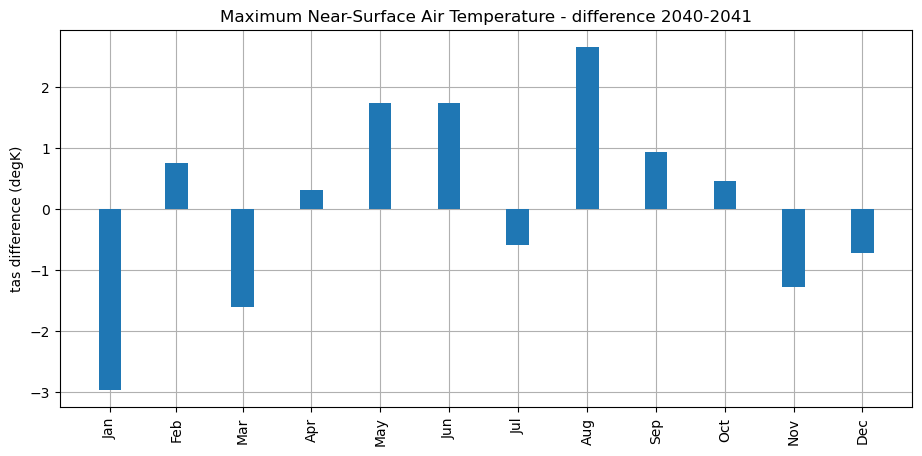

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt

data = diff.export_array()

y = data['measure'][0]['values'][0][:]
x = data['dimension'][2]['values'][:]
plt.figure(figsize=(11, 5), dpi=100)
plt.grid(zorder=0)
plt.bar(x, y, width=10, zorder=2)

plt.ylabel(data['measure'][0]['name'] + " difference (degK)")
plt.title('Maximum Near-Surface Air Temperature - difference 2040-2041')
plt.xticks(x, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation='vertical')
plt.show()

Our workspace now contains several datacubes from the operators just run.

In [94]:
cube.Cube.list(level=2)

Ophidia Filesystem: /
---------------------
+===+===============================================================+============================+====================+
| T | PATH                                                          | DATACUBE PID               | DESCRIPTION        |
|   |                                                               |                            |                    |
+===+===============================================================+============================+====================+
| c | tas_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_20400101-20641231.nc  | http://127.0.0.1/ophidia/4 | Imported cube      |
|   |                                                               | /14                        |                    |
|---|---------------------------------------------------------------|----------------------------|--------------------|
| c | tas_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_20400101-20641231.nc  | http://127.0.0.1/ophidia/4 | Reduced cube     

Once done, we can clear the space before moving to other notebooks. By default, the name of the container is equal to the name of the NetCDF file imported (we can get the filename as basename of the path returned by the intake-esm utility).

In [95]:
import os
cube.Cube.deletecontainer(container=os.path.basename(netcdf_file),force='yes')
cube.Cube.deletecontainer(container=os.path.basename(netcdf_file2),force='yes')

The virtual file system should now be "clean"

In [96]:
cube.Cube.list(level=2)

Ophidia Filesystem: /
---------------------
+===+======+==============+=============+
| T | PATH | DATACUBE PID | DESCRIPTION |
|   |      |              |             |
+===+======+==============+=============+
Execution time: 0.81 seconds
